In [53]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

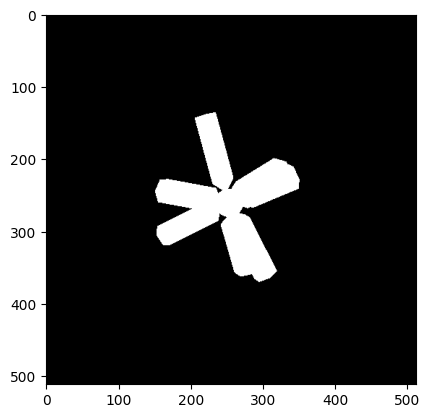

In [54]:
img_file = '/Users/josephko/research/ice_renders/20230419/2d-projections/ros_n7_a0.50_c2.00_2.png'
# img = cv.imread(img_file, cv.IMREAD_GRAYSCALE)
im = cv.imread(img_file)
img = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
assert img is not None, "file could not be read, check with os.path.exists()"
plt.imshow(img, cmap=plt.cm.gray)

<Axes: >

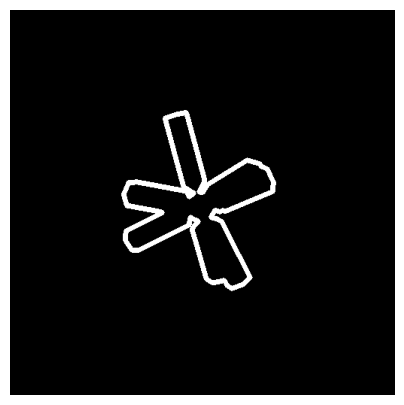

In [56]:
image = cv.imread(img_file)
image = cv.cvtColor(image, cv.COLOR_BGR2YCR_CB)[...,0]

def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha, cmap=plt.cm.gray)
    ax.set_axis_off()
    return ax

def getBordered(image, width):
    bg = np.zeros(image.shape)
    contours, _ = cv.findContours(image.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    biggest = 0
    bigcontour = None
    for contour in contours:
        area = cv.contourArea(contour) 
        if area > biggest:
            biggest = area
            bigcontour = contour
    return cv.drawContours(bg, [bigcontour], 0, (255, 255, 255), width).astype(bool), contours 

im2, contours = getBordered(image, 5)

show_img(im2, figsize=(5,5))

## Calculate geometric features

In [57]:
cnt = contours[0]

In [59]:
# Calcute aspect ratio (phi) from rectangle
rect = cv.minAreaRect(cnt)
# get length and width of contour
x = rect[1][0]
y = rect[1][1]
rect_length = max(x, y)
rect_width = min(x, y)
phi = rect_width / rect_length
print('Aspect ratio:', phi)

Aspect ratio: 0.9942537692160157


In [70]:
# Fit ellipse and return ellipse based aspect ratio
ellipse = cv.fitEllipse(cnt)
# Get width and height of rotated ellipse
widthE = ellipse[1][0]
heightE = ellipse[1][1]
if widthE > heightE:
    phiE = heightE / widthE
else:
    phiE = widthE / heightE
print('width & height of ellipse:', widthE, heightE)
print('aspect ratio of ellipse:', phiE)

width & height of ellipse: 172.83090209960938 202.30142211914062
aspect ratio of ellipse: 0.8543237130474778


In [72]:
"""
Computes how separated the outer most points are on the largest contour.
Higher std. deviation = more spread out
"""
left = tuple(cnt[cnt[:, :, 0].argmin()][0])
right = tuple(cnt[cnt[:, :, 0].argmax()][0])
top = tuple(cnt[cnt[:, :, 1].argmin()][0])
bottom = tuple(cnt[cnt[:, :, 1].argmax()][0])
extreme_points = np.std([left, right, top, bottom])
print("std of extreme points:", extreme_points)

std of extreme points: 78.94687691732967


In [73]:
# Calculate contour area and perimeter
area = cv.contourArea(cnt)
perimeter = cv.arcLength(cnt, True)
print('Contour Area:', area)
print('Contour Perimeter:', perimeter)

Contour Area: 17304.5
Contour Perimeter: 1174.4722119569778


In [24]:
# Calculate area and perimeter of minimally enclosing circle
(x,y),radius = cv.minEnclosingCircle(cnt)
center = (int(x),int(y))
# cv.circle(img,center,radius,(0,255,0),2)
perimeter_circle = 2*np.pi*radius
area_circle = np.pi*(radius**2)
print('Area of minimally enclosing circle:', area_circle)
print('Perimeter of minimally enclosing circle:', perimeter_circle)

Area of minimally enclosing circle: 47039.93028951013
Perimeter of minimally enclosing circle: 768.8440659142815


In [50]:
# Calculate area ratio 
area_ratio = area/area_circle
print('Area ratio:', area_ratio)

Area ratio: 0.36786831726787


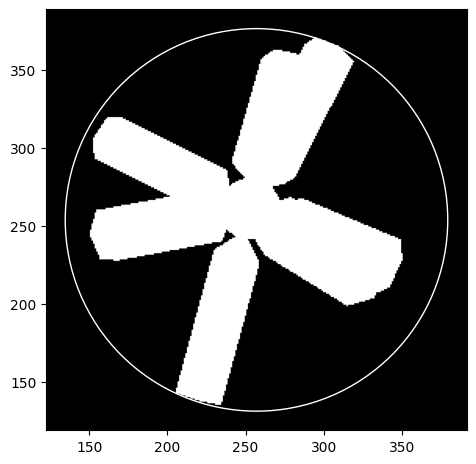

In [76]:
# visualize enclosing circle
fig, ax = plt.subplots()
fig.tight_layout()
draw_circle = plt.Circle(center, radius, fill=False, color='white')
ax.set_aspect(1)
ax.add_patch(draw_circle)
ax.axis('scaled')
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

In [ ]:
"""
How intricate & complicated the particle is
see:
    Schmitt, C. G., and A. J. Heymsfield (2014),
    Observational quantification of the separation of
    simple and complex atmospheric ice particles,
    Geophys. Res. Lett., 41, 1301–1307, doi:10.1002/ 2013GL058781.
"""
Ac = np.pi * radius ** 2
complexity = 10*(0.1-(area / (np.sqrt(area / Ac) * perimeter ** 2))

In [51]:
# Calculate circularity 
# used definition from cocpit: https://github.com/vprzybylo/cocpit
circularity = 4*np.pi*(area/(perimeter**2))
print('circularity:', circularity) 

circularity: 0.15764617128341923


In [3]:
ret,thresh = cv.threshold(img,120,255,0)
# contours,hierarchy = cv.findContours(thresh, 1, 2)
contours,hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
M = cv.moments(cnt)
print(M)

{'m00': 17304.5, 'm10': 4319258.333333333, 'm01': 4505982.0, 'm20': 1116241950.25, 'm11': 1128322639.4583333, 'm02': 1217897314.25, 'm30': 297475040894.8, 'm21': 292484116103.2833, 'm12': 306162842363.18335, 'm03': 340200822691.10004, 'mu20': 38141308.794341564, 'mu11': 3615175.8881636295, 'mu02': 44568192.6733002, 'mu30': -182890703.45269942, 'mu21': 17076163.716816485, 'mu12': 289054696.5997241, 'mu03': -142459332.40186688, 'nu20': 0.1273730302857503, 'nu11': 0.012072892159371677, 'nu02': 0.1488356308318292, 'nu30': -0.0046429498454799035, 'nu21': 0.00043350356356897937, 'nu12': 0.0073380791564401455, 'nu03': -0.003616539949136794}


In [4]:
print("Number of Contours found = " + str(len(contours)))

Number of Contours found = 1


In [ ]:
cv.drawContours(img, contours, -1, (0, 255, 0), 3)
# Show the image with contours
cv.imshow('Contours', img)
cv.waitKey(0)

#im an H X W array.
contours, hierarchy = cv.findContours(im, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
im = np.expand_dims(im, axis=2).repeat(3, axis=2) 
for k, _ in enumerate(contours):
    im = cv.drawContours(im, contours, k, (0, 230, 255), 6)
plt.imshow(im)

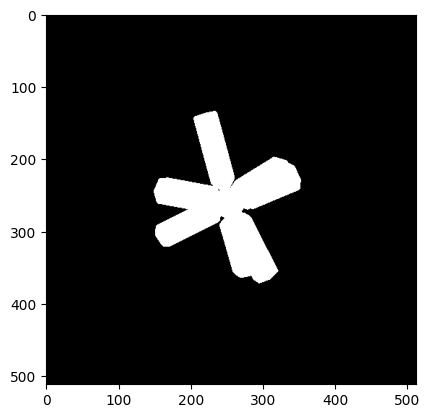

In [6]:
# draw all contours
img_plt = cv.drawContours(img, contours, -1, (255,0,0), 3)
plt.imshow(img_plt, cmap=plt.cm.gray)
# plt.figure()
# plt.imshow(img, cmap=plt.cm.gray)

In [ ]:
# Contoured image
ret,thresh = cv2.threshold(imgray, 120,255,cv2.THRESH_BINARY)
contours = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2]
for contour in contours:
   cv2.drawContours(im, contour, -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(im)

In [ ]:
# centroids
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
print(cx, cy)

In [ ]:
# contour area
area = cv.contourArea(cnt)